# CycleGAN for Image Transformation

Today you are a MLE at Uber Perception Stack Team!

Your team is developing new software around automated detection of cars, pedestrians at all conditions for autonomous drive. One major bottleneck is data collection under severe weather conditions, especially capturing night-time images. So your task is to generate night time equivalent images from daytime images, such that you have access to some outdoor images acquired at night and some at day, but no pairwise images are available.

*Pairwise image means*: same view available in Day and Night times.

In this assignment we implement CycleGAN using Keras with the intention to transform Day time to night time images for Autonomous Drive like in:
https://github.com/simontomaskarlsson/CycleGAN-Keras

This work is an adaptation of the blog in: https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/

__Lets start with the concepts of CycleGAN__

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B). Lets consider here, **Domain-A: Daytime**, **Domain-B: Nighttime**

* Generator-A -> Domain-A
* Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

* Domain-B -> Generator-A -> Domain-A
* Domain-A -> Generator-B -> Domain-B
Each generator has a corresponding discriminator model.

The first discriminator model (Discriminator-A) takes real images from Domain-A (daytime images) and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B (night-time images) and generated images from Generator-B and predicts whether they are real or fake.

* Domain-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Discriminator-B -> [Real/Fake]
* Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]
The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models.

The generators learn to better fool the discriminators and the discriminators learn to better detect fake images. Together, the models find an equilibrium during the training process.

Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

* Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
* Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A


**Our goal is to train such a 2 set Generator-Discriminator pair, to finally generate night-time images from day-time ones and quantify performance...**



## Task 0: Install libraries and load data

1. Make sure you the `tensorflow-addons` package is up-to-date.

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


2. If running in Google Colab, mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Task 1 [Instructor Led]:  Design functions for Generator-Discriminator pairs**: 


Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

1. Define a Patchgan discriminator model.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization
from tensorflow_addons.layers import InstanceNormalization

def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02) # weight initialization
    in_image = Input(shape=image_shape) # source image input
    # C64
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d) #Stride reduces shape of image
    # C128
    d = Conv2D(128, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C256
    d = Conv2D(256, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # C512
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    # second last output layer
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    model = Model(in_image, patch_out)
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model

2. Build the model and use the `plot_model()` function to view the model layers.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


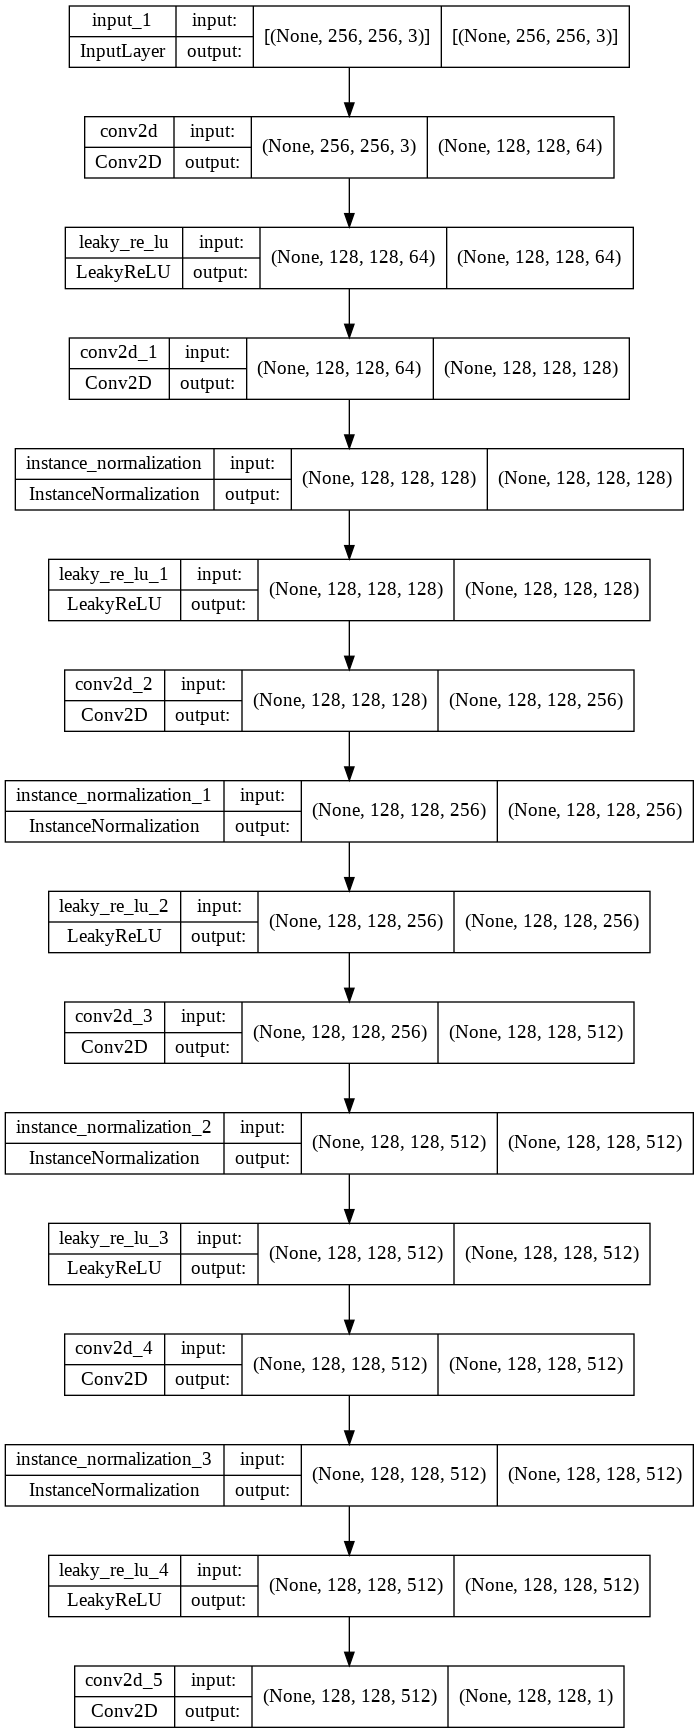

In [ ]:
from tensorflow.keras.utils import plot_model

image_shape = (256, 256, 3)
model = define_discriminator(image_shape)
plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

3. Define the Generator Model.

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Activation, Concatenate

def resnet_block(n_filters, input_layer):
    init = RandomNormal(stddev=0.02) # weight initialization
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization()(g)
    # concatenate merge channel-wise with input layer
    return Concatenate()([g, input_layer])

def define_generator(image_shape=(256, 256, 3), n_resnet=9):
    init = RandomNormal(stddev=0.02) # weight initialization
    in_image = Input(shape=image_shape) # image input
    # c7s1-64
    g = Conv2D(64, (7, 7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    # d128
    g = Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    # d256
    g = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    # R256
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    # u128
    g = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    # u64
    g = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization()(g)
    g = Activation('relu')(g)
    # c7s1-3
    g = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization()(g)
    out_image = Activation('sigmoid')(g)
    return Model(in_image, out_image)

4. Build the model and use the `plot_model()` function to view the model layers.

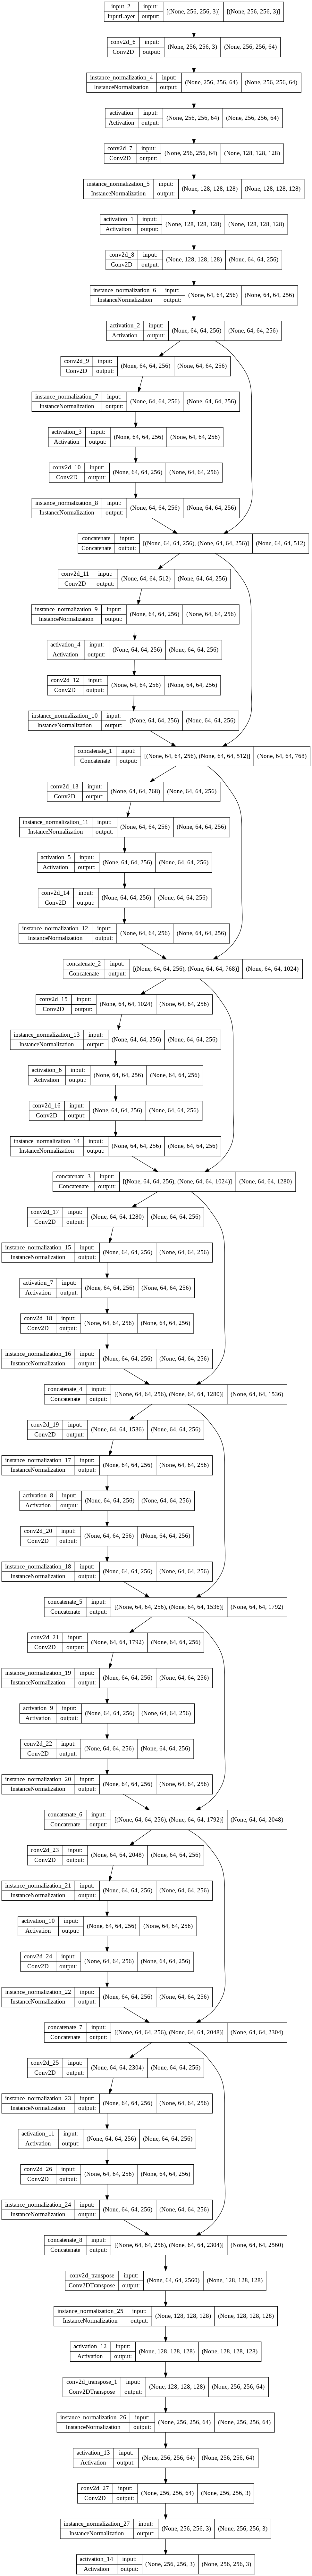

In [ ]:
model = define_generator()
plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

5. Define a composite model for updating generators by adversarial and cycle loss.

In [ ]:
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # Mark g_model_1 as trainable, d_model & g_model_2 as untrainable
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    # discriminator element
    input_gen = Input(shape=image_shape)
    gen1_out = g_model_1(input_gen)
    output_d = d_model(gen1_out)
    # identity element
    input_id = Input(shape=image_shape)
    output_id = g_model_1(input_id)
    # forward cycle
    output_f = g_model_2(gen1_out)
    # backward cycle
    gen2_out = g_model_2(input_id)
    output_b = g_model_1(gen2_out)

    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
    return model

6. Run the functions to generate the models.

In [ ]:
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


7. Define the function `generate_real_samples()` which selects a random batch of sampels and returns the image and target. Note that we first define the `randnums()` helper function to select real samples and generate fake samples.

In [ ]:
from random import randint
import numpy as np

def randnums(start, stop, n_samples):
    ix = []
    for i in range(n_samples):
        ix.append(randint(start, stop))
        ix = np.array(ix)
    return ix

def generate_real_samples(dataset, n_samples, patch_shape):
    ix = randnums(0, dataset.shape[0]-1, n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

8. Define the function `generate_fake_samples()` which generates a batch of images and returns the images and targets.

In [ ]:
def generate_fake_samples(g_model, dataset, patch_shape):
    X = g_model.predict(dataset)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

9. Define the function `update_image_pool()` which updates the image pool for fake images.

In [ ]:
from random import random

def update_image_pool(pool, images, max_size=50):
    selected = []
    for image in images:
        if len(pool) < max_size:
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # use image, but don't add it to the pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = randint(0, len(pool) - 1)
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

### Now we're ready to begin training!

10. Define the `train()` function for the cyclegan models. It will complete these tasks:
    * Update Generator-B (A->B)
    * Update Discriminator-B
    * Update Generator-A (B->A)
    * Update Discriminator-A
    
    Note: Keep `n_batch` as 1 for per image training. `n_epochs` and `n_patch` can be changed.

In [ ]:
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, trainA, trainB):
    n_epochs, n_batch = 10, 1
    n_patch = d_model_A.output_shape[1]
    
    poolA, poolB = [], []
    bat_per_epo = int(len(trainA) / n_batch)
    n_steps = bat_per_epo * n_epochs

    for i in range(n_steps):
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)

        # update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA],
                                                          [y_realA, X_realA, X_realB, X_realA])
        
        # update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        # update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB],
                                                          [y_realB, X_realB, X_realA, X_realB])
        
        # update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

        # summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' %
              (i + 1, dA_loss1, dA_loss2, dB_loss1, dB_loss2, g_loss1, g_loss2))

    return g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA

## **Task 2: Train the model from scratch** 

1. Download the image files. Change your working directory to where you saved the image files.

In [ ]:
import os
os.chdir('/content/drive/My Drive/FourthBrain/Assignments/Week_9/training_images/')

2. We will be using the opencv package for image processing. If you are running locally and don't have the `cv2` module installed, install it: `pip install opencv-python`.

3. Load the images. We define a `load_images()` helper function. Note that we're loading just 30 of images to limit training time. You could increase this number, but more images will require more epochs and more train time.

    We verify the shape of the `day_images` and `night_images` arrays. They should both have 30 images of size 256 by 256 with 3 channels

In [ ]:
from PIL import Image
import cv2

def load_images(path, num=30):
    image_names = os.listdir(path)
    images = []
    for i in range(num):
        filename = image_names[i]
        image = np.array(Image.open(os.path.join(path, filename)))
        image_scaled = image / 255
        image_resized = cv2.resize(image_scaled, (256, 256))
        images.append(image_resized)
    return np.array(images)

day_images = load_images('day')
night_images = load_images('night')

4. Call the train function to train on the images.

In [ ]:
g_day2night, g_night2day, c_day2night, c_night2day = train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, day_images, night_images)

>1, dA[2.084,3.146] dB[1.268,4.419] g[11.708,13.708]
>2, dA[8.004,1.979] dB[11.152,7.919] g[10.396,19.185]
>3, dA[6.266,2.290] dB[3.147,7.074] g[13.084,10.406]
>4, dA[10.767,5.385] dB[5.424,6.641] g[12.663,13.338]
>5, dA[1.505,5.477] dB[2.747,3.354] g[10.683,14.328]
>6, dA[0.664,8.668] dB[3.145,1.713] g[9.705,20.050]
>7, dA[1.023,3.334] dB[2.012,1.246] g[9.418,12.152]
>8, dA[0.580,1.538] dB[0.882,3.956] g[10.193,8.421]
>9, dA[0.291,0.810] dB[0.339,5.154] g[9.540,6.686]
>10, dA[0.184,0.280] dB[0.276,1.537] g[9.240,7.527]
>11, dA[0.220,0.304] dB[0.223,0.403] g[5.709,5.271]
>12, dA[0.307,0.302] dB[0.196,0.216] g[6.657,6.038]
>13, dA[0.181,0.222] dB[0.163,0.175] g[6.699,6.433]
>14, dA[0.164,0.225] dB[0.204,0.184] g[6.885,7.316]
>15, dA[0.220,0.397] dB[0.191,0.156] g[6.056,5.808]
>16, dA[0.164,0.303] dB[0.185,0.135] g[5.850,5.506]
>17, dA[0.178,0.159] dB[0.254,0.160] g[8.092,6.824]
>18, dA[0.175,0.142] dB[0.197,0.158] g[5.648,5.036]
>19, dA[0.142,0.134] dB[0.163,0.110] g[5.682,4.999]
>20, d

## Task 3: Write a  function to generate fake images for the test set

We'll create Day->Night and  Night->Day versions separately and visualize some images.

Think about what parameters you could change to improve the model.

1. Define the `gen_day_night()` function which generates day to night images. Fill in the code where there are `None`'s.

    Hint: Follow the format of the `train()` function.

In [ ]:
import matplotlib.pyplot as plt

def gen_day_night(g_day2night, g_night2day, c_day2night, c_night2day, trainA, trainB):
    # Define properties of the training run
    n_epochs, n_batch = 1, 1
    
    # Determine the output square shape of the discriminator
    n_patch = 64
    
    n_steps = 2
    for step in range(n_steps):
        # Select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

        # Generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch) 
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

        # First Day to night transformation
        print('Original Day Image is=\n')
        plt.imshow(np.squeeze(X_realA))
        plt.show()
        print('Fake Night image is=\n')
        plt.imshow(np.squeeze(X_fakeB))
        plt.show()
        # Next Night to Day transformation
        print('Original Night Image is=\n')
        plt.imshow(np.squeeze(X_realB))
        plt.show()
        print('Fake Day image is=\n')
        plt.imshow(np.squeeze(X_fakeA))
        plt.show()

Original Day Image is=



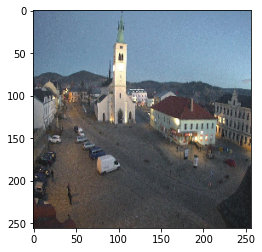

Fake Night image is=



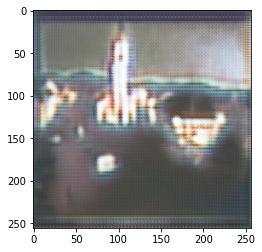

Original Night Image is=



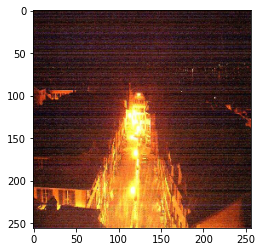

Fake Day image is=



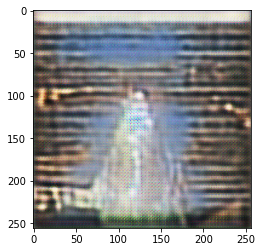

Original Day Image is=



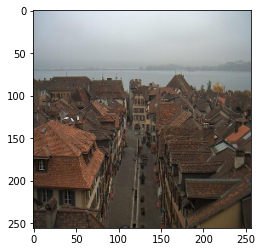

Fake Night image is=



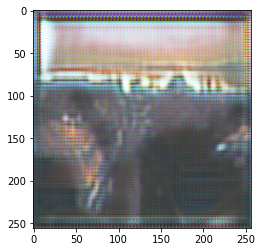

Original Night Image is=



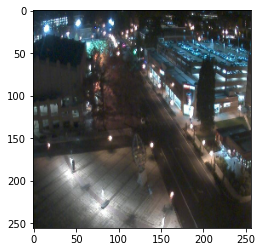

Fake Day image is=



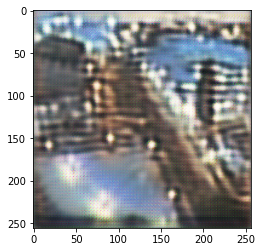

In [ ]:
gen_day_night(g_day2night, g_night2day, c_day2night, c_night2day, day_images, night_images)

2. Notice a banding around edges for the nighttime images. What parameter would you change to reduce this banding?

## Summary and Discussion:

**Discuss** "What domain transformation is better quality (day to night to day or night to day to night?) and what are some ways to ensure quality transformations?

Think in terms of Data, Process and Outcomes specifically.

__Consider the following__:
1. Can you process the data in some other way? Optimal image size? Patch size?
2. Given a new data set on the job, how would you report the best "method"? (which transformation and why?)
3. What is the metric/metrics you would use to report your results?

Share screen and discuss findings. What about generalizability (something that works across data sets)?

Comment on which domain transformation is better quality and some steps to improve performance.

